In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.datasets
import utils

from nn_framework.op import Variable, Const, Placeholder
from nn_framework.utils import Ones, ReLU, Sigmoid, LogisticLoss
from nn_framework.gradient_check import gradient_check
from nn_framework.optimizers import GradientDescentOptimizer
from nn_framework.session import Session

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def dense(X, input_dim, output_dim):
  W = Variable(np.random.randn(output_dim, input_dim))
  b = Variable(np.zeros([output_dim, 1]))
  return W @ X + b

X.shape = (2, 1000), Y.shape = (1, 1000)


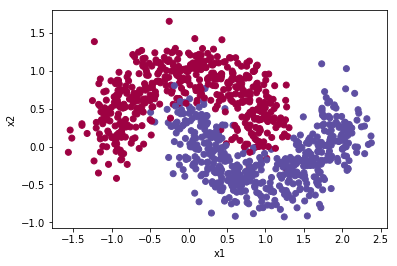

In [3]:
m = 1000
X, Y = sklearn.datasets.make_moons(m, noise=0.2)
X = X.T
Y = Y.reshape(-1, 1).T

print('X.shape = %s, Y.shape = %s' % (X.shape, Y.shape))
plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')

In [4]:
def compare(a, b):
  return np.linalg.norm(a - b) / (np.linalg.norm(a) + np.linalg.norm(b))

tf.reset_default_graph()
m = 1000
n = 20
n_h = 50

w = np.random.randn(n_h, n)
b = np.random.randn(n_h, 1)
t1 = np.random.randn(n, n_h)
t2 = np.random.randn(n, m)

# TensorFlow
wtf = tf.constant(w)
biastf = tf.constant(b)
atf = wtf * 2
atf *= atf
btf = (tf.matmul(t1, tf.matmul(wtf, t2)) + 1) * 2 - 3
btf *= btf

ztf = tf.matmul(atf, btf) + biastf ** 2
ztf *= ztf
[dwtf, dbtf] = tf.gradients(ztf, [wtf, biastf])

# My :D
wmy = Variable(w)
biasmy = Variable(b)
amy = wmy * Const(2)
amy *= amy
bmy = (Const(t1) @ wmy @ Const(t2) + Const(1)) * Const(2) - Const(3)
bmy *= bmy

zmy = amy @ bmy + biasmy ** Const(2)
zmy *= zmy
dwmy, dbmy = zmy.deriv(wmy, Ones(zmy.shape)), zmy.deriv(biasmy, Ones(zmy.shape))

with tf.Session() as sess:
  [dwtf_val, dbtf_val] = sess.run([dwtf, dbtf])
  [dwmy_val, dbmy_val] = Session().run([dwmy, dbmy], {})
  
  assert dwtf_val.shape == dwmy_val.shape, 'dw shapes should match'
  assert dbtf_val.shape == dbmy_val.shape, 'db shapes should match'
  
  dw_mse = compare(dwtf_val, dwmy_val)
  db_mse = compare(dbtf_val, dbmy_val)
  
  print('actual test: dw mse: %s, db mse: %s' % (dw_mse, db_mse))

actual test: dw mse: 2.21837876813e-16, db mse: 1.45872500601e-16


3.9740872253e-09
loss: 2.601934
step: 0, loss: 2.601934, accuracy: 50.0
step: 500, loss: 0.222584, accuracy: 90.4
step: 1000, loss: 0.169123, accuracy: 94.0
step: 1500, loss: 0.130881, accuracy: 95.5
step: 2000, loss: 0.107714, accuracy: 96.4
step: 2500, loss: 0.096409, accuracy: 96.7
step: 3000, loss: 0.090076, accuracy: 96.4
step: 3500, loss: 0.085353, accuracy: 96.6
step: 4000, loss: 0.082061, accuracy: 96.8
step: 4500, loss: 0.079673, accuracy: 96.9
step: 5000, loss: 0.077575, accuracy: 97.0
step: 5500, loss: 0.076105, accuracy: 97.2
step: 6000, loss: 0.074948, accuracy: 97.3
step: 6500, loss: 0.074027, accuracy: 97.3
step: 7000, loss: 0.073263, accuracy: 97.4
step: 7500, loss: 0.072612, accuracy: 97.4
step: 8000, loss: 0.072085, accuracy: 97.4
step: 8500, loss: 0.071642, accuracy: 97.4
step: 9000, loss: 0.071268, accuracy: 97.2
step: 9500, loss: 0.070948, accuracy: 97.3


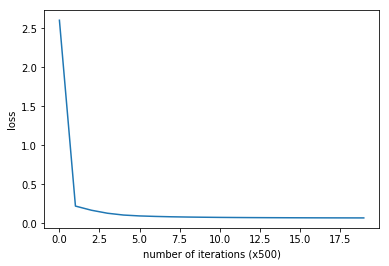

In [5]:
learning_rate = 0.1
steps = 10000
log_interval = 500

assert X.shape[0] == 2

A0 = Placeholder('X', [X.shape[0], None])
net = A0
net = dense(net, input_dim=2, output_dim=16)
net = ReLU(net)
net = dense(net, input_dim=16, output_dim=1)  
net = Sigmoid(net)
Y_hat = net

loss = LogisticLoss(a=Y_hat, y=Const(Y))
print(gradient_check(loss, {A0: X}))
train = GradientDescentOptimizer(learning_rate, loss)
losses = []

sess = Session()
print('loss: %f' % sess.run([loss], {A0: X})[0])

for i in range(0, steps):
  _, l, Y_hat_val = sess.run([train, loss, Y_hat], {A0: X})
  
  if i % log_interval == 0:
    acc = np.mean(Y == (Y_hat_val > 0.5)) * 100
    print('step: %d, loss: %f, accuracy: %s' % (i, l, acc))
    losses.append(l)
    
plt.plot(losses)
plt.xlabel('number of iterations (x%s)' % log_interval)
plt.ylabel('loss')

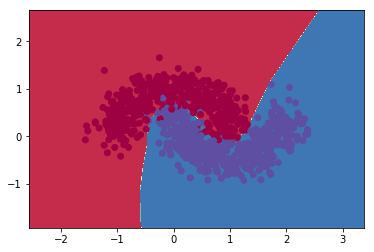

In [6]:
utils.plot_decision_boundary(lambda x: sess.run([Y_hat], {A0: x.T})[0] > 0.5, X, Y, cmap=plt.cm.Spectral)